In [ ]:
import os
import csv

# Path to your CSV file
csv_file_path = '/content/drive/MyDrive/DermatoAI/SeturiDateFinaleClasificareBoliPiele/Dataset-agumentat-mediu-undersampling/metadata.csv'

# Directory where your images are stored
image_directory = '/content/drive/MyDrive/DermatoAI/SeturiDateFinaleClasificareBoliPiele/Dataset-agumentat-mediu-undersampling/dataset'

missing_files = []
i = 0
# Assuming your CSV has headers and 'isic_id' is the column with image filenames
with open(csv_file_path, mode='r') as file:
    reader = csv.DictReader(file)
    for row in reader:
        isic_id = row['isic_id']  # Adjust the key if your column name is different
        image_path = os.path.join(image_directory, f"{isic_id}")  # Adjust extension if needed
        if not os.path.exists(image_path):
            missing_files.append(isic_id)

# Print the number of missing files and some examples
print(f"Total missing files: {len(missing_files)}")
if len(missing_files) > 0:
    print("Examples of missing files:", missing_files[:10])



Total missing files: 0


In [3]:
!cp -r "/content/drive/MyDrive/DermatoAI/SetClasificareBoliBalanced" "/content/sample_data"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!unzip "/content/drive/MyDrive/DermatoAI/SetClasificareBoliBalanced.zip" -d "/content/drive/MyDrive/DermatoAI"


In [4]:
import os

def count_files(directory):
    total_files = 0
    for root, dirs, files in os.walk(directory):
        total_files += len(files)
    return total_files
print(count_files('/content/sample_data/SetClasificareBoliBalanced'))

12000


Found 8400 images belonging to 8 classes.
Found 3600 images belonging to 8 classes.
Class Indices: {'actinic_keratosis': 0, 'basal_cell_carcinoma': 1, 'dermatofibroma': 2, 'melanoma': 3, 'nevus': 4, 'pigmented_benign_keratosis': 5, 'squamous_cell_carcinoma': 6, 'vascular_lesion': 7}
Index to Class: {0: 'actinic_keratosis', 1: 'basal_cell_carcinoma', 2: 'dermatofibroma', 3: 'melanoma', 4: 'nevus', 5: 'pigmented_benign_keratosis', 6: 'squamous_cell_carcinoma', 7: 'vascular_lesion'}
Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_17 (InputLayer)       [(None, 450, 600, 3)]        0         []                            
                                                                                                  
 conv2d_1624 (Conv2D)        (None, 224, 299, 32)         864       ['input_17[0][0]']            
  

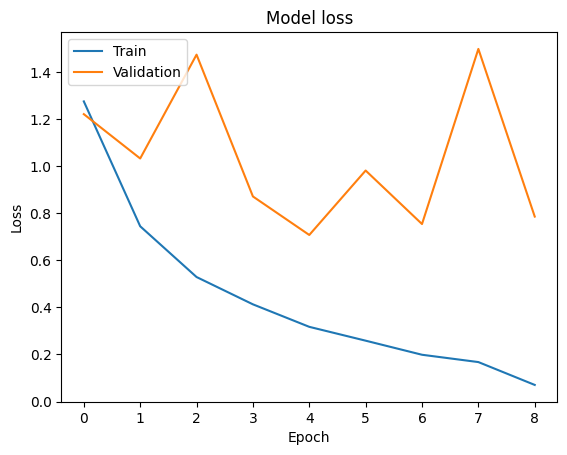

225/225 [==============================] - 27s 107ms/step


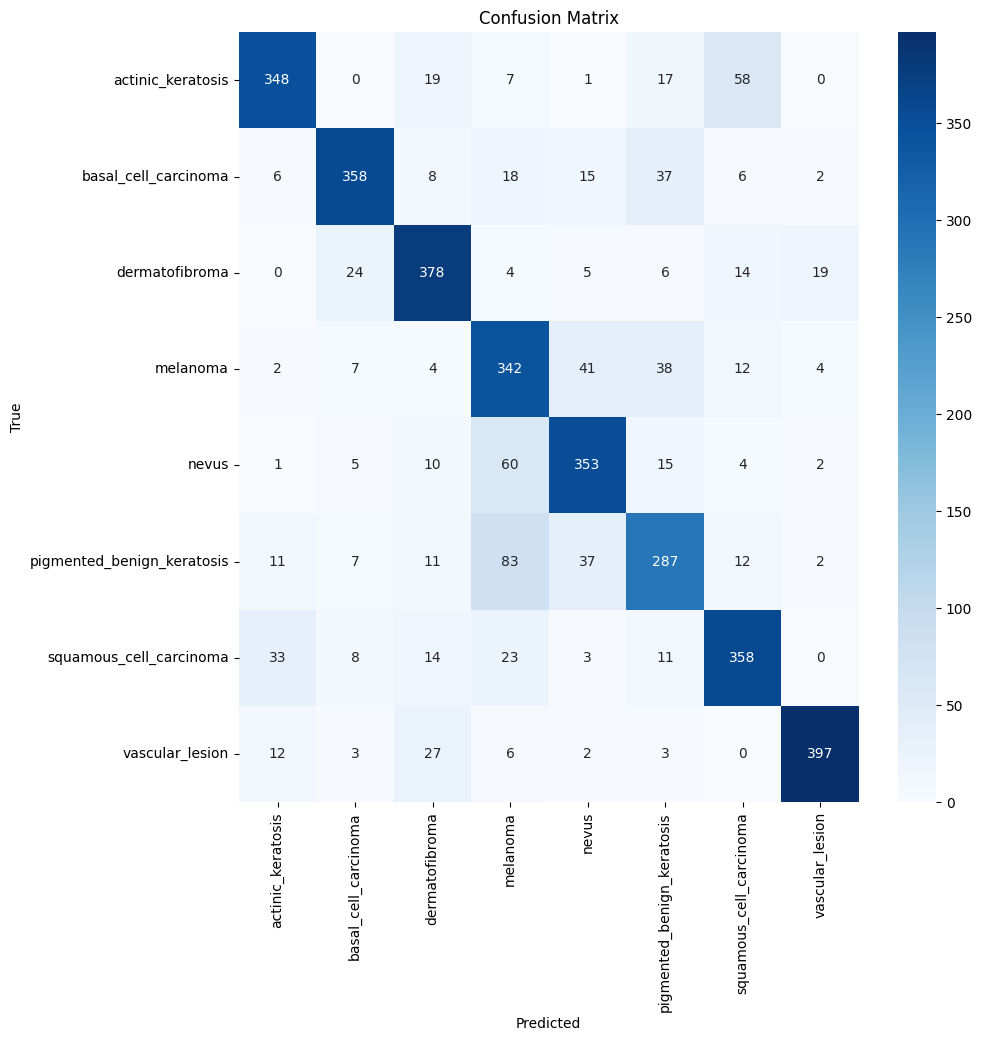

                            precision    recall  f1-score   support

         actinic_keratosis       0.84      0.77      0.81       450
      basal_cell_carcinoma       0.87      0.80      0.83       450
            dermatofibroma       0.80      0.84      0.82       450
                  melanoma       0.63      0.76      0.69       450
                     nevus       0.77      0.78      0.78       450
pigmented_benign_keratosis       0.69      0.64      0.66       450
   squamous_cell_carcinoma       0.77      0.80      0.78       450
           vascular_lesion       0.93      0.88      0.91       450

                  accuracy                           0.78      3600
                 macro avg       0.79      0.78      0.78      3600
              weighted avg       0.79      0.78      0.78      3600



/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [21]:
import pandas as pd
import tensorflow as tf
from keras.src.layers import Flatten
from sklearn.utils import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import numpy as np
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.applications import InceptionResNetV2



np.random.seed(42)
target_size = (450, 600)
batch = 16
epoci = 20

class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * ((p * r) / (p + r + K.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()


image_directory = '/content/sample_data/SetClasificareBoliBalanced'


datagen = ImageDataGenerator(rescale=1./255, validation_split=0.3)  # 30% of data for validation

# Create the training generator
train_generator = datagen.flow_from_directory(
    directory=image_directory,  # Make sure this is the path to the image directory
    target_size=target_size,
    shuffle=True,
    batch_size=batch,
    class_mode='categorical',  # Using 'categorical' since you have more than 2 classes
    subset='training',  # Set subset to training
    seed=42
)

# Create the validation generator
validation_generator = datagen.flow_from_directory(
    directory=image_directory,  # Make sure this is the path to the image directory
    target_size=target_size,
    shuffle=False,
    batch_size=batch,
    class_mode='categorical',  # Using 'categorical' since you have more than 2 classes
    subset='validation',  # Set subset to validation
    seed=42
)

class_indices = train_generator.class_indices

# Print the class indices
print("Class Indices:", class_indices)

# Invert the dictionary to map indices to class names
index_to_class = {v: k for k, v in class_indices.items()}
print("Index to Class:", index_to_class)


base_model = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=(target_size[0], target_size[1], 3))
for layer in base_model.layers[:-100]:  # This is just an example; adjust the number as needed
    layer.trainable = False
# Freeze the convolutional base
#base_model.trainable = False

# Build the model
x = base_model.output
x = GlobalAveragePooling2D()(x)

# x = Dense(512)(x)  # Notice the removal of the activation function here
# x = BatchNormalization()(x)  # Add batch normalization layer
# x = Activation('relu')(x)  # Apply the activation function after batch normalization
# x = Dropout(0.5)(x)  # Dropout to prevent overfitting

# Second Dense block
x = Dense(256)(x)  # Again, remove the activation function
x = BatchNormalization()(x)  # Batch Normalization layer
x = Activation('relu')(x)  # Apply the activation function afterward
x = Dropout(0.5)(x)  # Dropout layer



predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.0006),
              loss=CategoricalCrossentropy(),
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), F1Score()])

model.summary()


callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, min_lr=1e-6),
    EarlyStopping(monitor='val_loss',min_delta=0.001, mode='min', patience=4, verbose=1, restore_best_weights=True)
]

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.n // validation_generator.batch_size,
    # class_weight=class_weights,
    epochs=epoci,
    callbacks=callbacks
)

validation_generator.reset()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Predict on the whole validation set
predictions = model.predict(validation_generator, steps=np.ceil(validation_generator.n / validation_generator.batch_size))

# Get the class indices from the predictions
predicted_classes = np.argmax(predictions, axis=1)

# Retrieve the true class indices assigned by the generator
true_classes = validation_generator.classes

# Match the order of the class indices
class_labels = list(validation_generator.class_indices.keys())

# Generate the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Visualize the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Generate a classification report
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Save the model
model.save('/content/drive/MyDrive/DermatoAI/Models/balanced_MobileNet_2.h5')

In [ ]:
from google.colab import files
files.download('/content/drive/MyDrive/DermatoAI/mediu_undersampling_model1.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>